In [1]:
# Clone ETS repo
!git clone https://github.com/jaychempan/ETS.git

fatal: destination path 'ETS' already exists and is not an empty directory.


In [2]:
!mkdir -p data/coco
%cd data/coco

# Download 2017 annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Unzip
!unzip annotations_trainval2017.zip

# Optional: download validation images if needed
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

In [3]:
import json

with open('annotations/instances_val2017.json') as f:
    coco_data = json.load(f)
print(coco_data.keys())

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [4]:
# Few-shot subset creation
import random
from pycocotools.coco import COCO

In [5]:
def create_fewshot_subset(full_json_path, output_json_path, k_shot=5, selected_class_ids=None):
    coco = COCO(full_json_path)
    new_dataset = {'images': [], 'annotations': [], 'categories': coco.dataset['categories']}
    img_ids_collected = set()

    for cat in coco.loadCats(coco.getCatIds()):
        cat_id = cat['id']
        if selected_class_ids and cat_id not in selected_class_ids:
            continue
        ann_ids = coco.getAnnIds(catIds=[cat_id])
        anns = coco.loadAnns(ann_ids)
        img_to_anns = {}
        for ann in anns:
            img_to_anns.setdefault(ann['image_id'], []).append(ann)
        selected_imgs = random.sample(list(img_to_anns.keys()), min(k_shot, len(img_to_anns)))
        for img_id in selected_imgs:
            img_info = coco.loadImgs(img_id)[0]
            new_dataset['images'].append(img_info)
            new_dataset['annotations'].extend(img_to_anns[img_id])
            img_ids_collected.add(img_id)

    seen = set()
    new_dataset['images'] = [img for img in new_dataset['images'] if not (img['id'] in seen or seen.add(img['id']))]

    with open(output_json_path, 'w') as f:
        json.dump(new_dataset, f)
    print(f"Saved few-shot JSON at: {output_json_path}")

In [6]:
create_fewshot_subset(
    full_json_path='annotations/instances_val2017.json',
    output_json_path='annotations/instances_val2017_5shot.json',
    k_shot=5
)

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
Saved few-shot JSON at: annotations/instances_val2017_5shot.json


In [7]:
# Load and visualize few-shot samples
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import skimage.io

fewshot_coco = COCO('annotations/instances_val2017_5shot.json')
fewshot_img_ids = fewshot_coco.getImgIds()
print(f"Total few-shot images: {len(fewshot_img_ids)}")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Total few-shot images: 383


Object: elephant - bbox: [219.03, 64.9, 315.57, 238.5]
Object: elephant - bbox: [93.71, 79.66, 124.68, 255.87]
Object: stop sign - bbox: [183.67, 525.56, 17.1, 42.94]
Object: fire hydrant - bbox: [81.4, 219.71, 20.3, 70.39]
Object: fire hydrant - bbox: [404.77, 227.45, 16.95, 65.52]


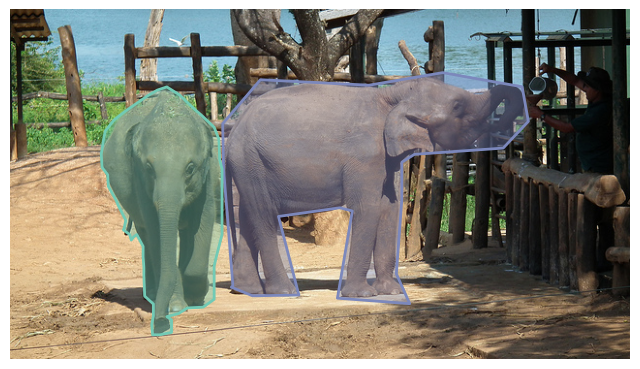

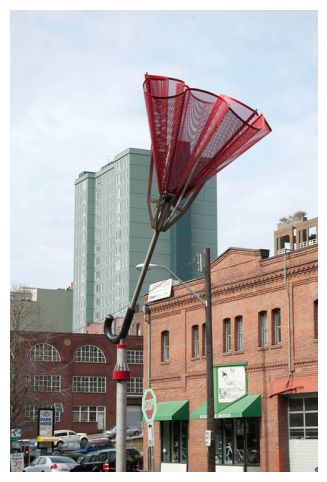

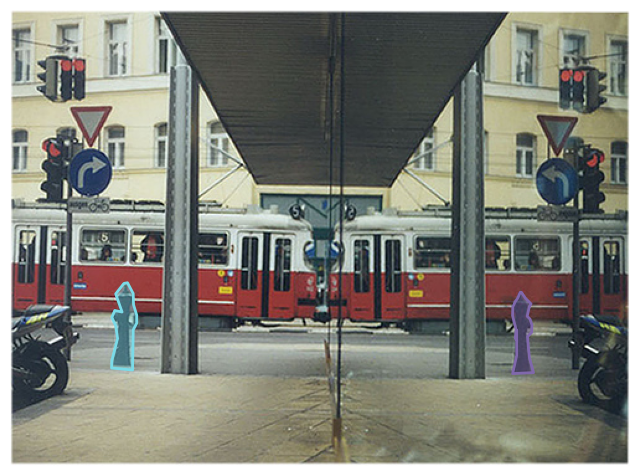

In [8]:
# Show 3 random few-shot images
for img_id in random.sample(fewshot_img_ids, 3):
    img_info = fewshot_coco.loadImgs(img_id)[0]
    img = skimage.io.imread(f'val2017/{img_info["file_name"]}')

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')

    ann_ids = fewshot_coco.getAnnIds(imgIds=img_info['id'])
    anns = fewshot_coco.loadAnns(ann_ids)
    fewshot_coco.showAnns(anns)

    for ann in anns:
        cat = fewshot_coco.loadCats(ann['category_id'])[0]
        print(f"Object: {cat['name']} - bbox: {ann['bbox']}")

In [9]:
# Install and load DETR model
!pip install transformers timm -q

In [10]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import numpy as np

In [11]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2025: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/usr/local/lib/python

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [12]:
# Inference on one sample image
image_path = "val2017/000000000139.jpg"
image = Image.open(image_path).convert("RGB")

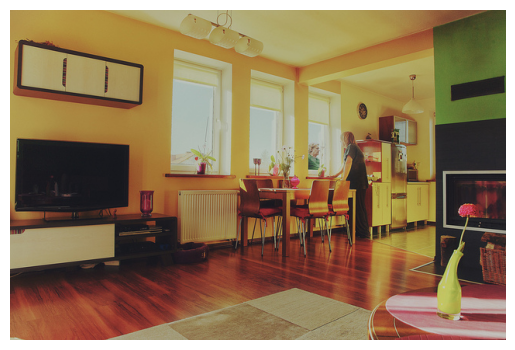

In [13]:
plt.imshow(image)
plt.axis("off")
plt.show()

In [14]:
# Process the image
inputs = processor(images=image, return_tensors="pt")

# Inference
with torch.no_grad():
    outputs = model(**inputs)

# Convert predictions to boxes
target_sizes = torch.tensor([image.size[::-1]])  # (height, width)
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

# Show results
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    print(f"Detected {model.config.id2label[label.item()]} with confidence {round(score.item(), 3)} at {box.tolist()}")

Detected vase with confidence 0.979 at [243.5902099609375, 198.5121307373047, 252.70932006835938, 212.39126586914062]
Detected chair with confidence 0.987 at [411.4083251953125, 219.8477020263672, 442.4589538574219, 304.99053955078125]
Detected vase with confidence 0.903 at [339.8709411621094, 201.70504760742188, 347.7676696777344, 216.7922821044922]
Detected microwave with confidence 0.923 at [512.6398315429688, 200.05445861816406, 529.7950439453125, 221.27447509765625]
Detected potted plant with confidence 0.923 at [343.3423156738281, 178.04722595214844, 367.4087829589844, 226.35818481445312]
Detected chair with confidence 0.998 at [294.2547302246094, 217.10093688964844, 354.2479248046875, 318.0825500488281]
Detected vase with confidence 0.979 at [166.51736450195312, 232.9876708984375, 186.89425659179688, 266.6836242675781]
Detected potted plant with confidence 0.99 at [227.54074096679688, 174.73423767089844, 268.4761962890625, 213.0324249267578]
Detected tv with confidence 0.997 at 

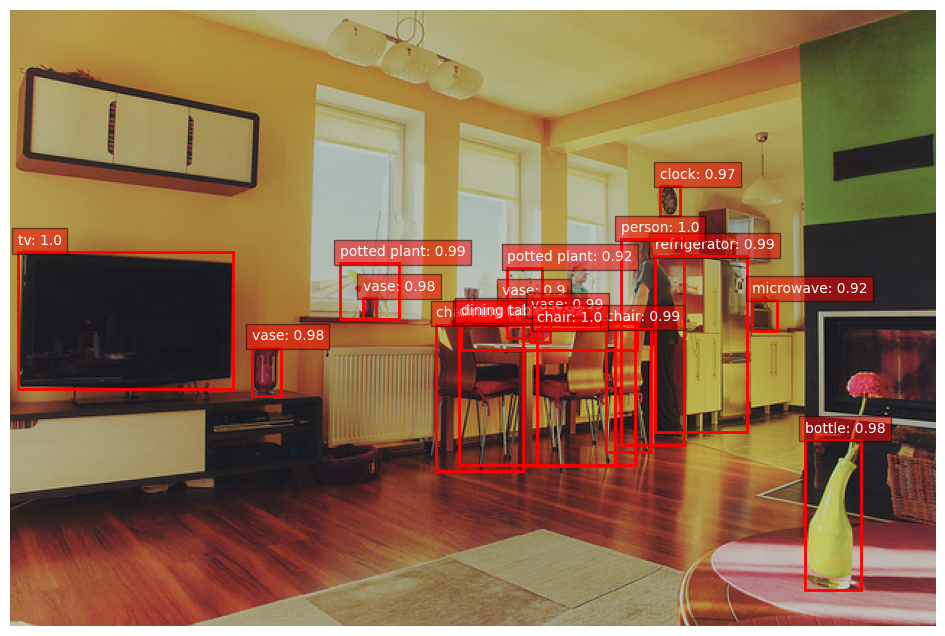

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Draw boxes on the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
ax = plt.gca()

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    xmin, ymin, xmax, ymax = box.tolist()
    width, height = xmax - xmin, ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    label_text = f"{model.config.id2label[label.item()]}: {round(score.item(), 2)}"
    plt.text(xmin, ymin - 5, label_text, color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()